In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
import tensorflow as tf
import seaborn as sns
import csv
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten, Input, Concatenate, Lambda, experimental
from tensorflow.keras.optimizers import SGD
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow import keras
from PIL import Image, ImageOps, ImageDraw
import os, glob
import numpy as np
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pandas as pd
import sklearn
import math
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import TensorBoard

#  Definir Tamanhos

In [7]:
processing = False
grayscale = True
g = 1
s = 3

if(grayscale == True):
    g = 0
    s = 1

#Se fizer load em RGB (1)
#Se fizer load em Grayscale (0)
h_W = 100
h = h_W
w = int(h_W*1)
size = (w,h)
input = (h,w,s)

# Cria arrays com imagens

In [9]:
#train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
train_path = "Organized Firing Pin/Train"
labels = os.listdir(train_path)

def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv2.LUT(src, table)

def create_lists(type):
    #train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
    train_path = "Organized Firing Pin/Train"
    labels = os.listdir(train_path)
    #Converte labels em labels binários 
    lb = preprocessing.LabelBinarizer()
    bin_lab = lb.fit_transform(labels)
    #path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/" + type
    path = "Organized Firing Pin/" + type
    image_set = []
    b_labels_set = []
    i_labels_set = []

    #Cria train_set e train_labels
    for i,b in zip(labels, bin_lab): 
        class_path = path + "/" + i

        carts = os.listdir(class_path)
        for cart in carts:
            #if "BFR" in cart or "BFS" in cart:
            img = cv2.imread(class_path +  "/" + cart, g)
            if processing == True:
                img_b = cv2.medianBlur(img, 5)
                eq = gammaCorrection(img_b, 2)
                (T, thresh) = cv2.threshold(eq, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
                img = cv2.bitwise_and(img,img,mask = thresh)
            #img = img[int(len(img)*0.15):int(len(img)*0.85),int(len(img[0])*0.23):int(len(img[0])*0.77)]
            img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
            img = np.reshape(img, input)
            image_set.append(img/255)
            b_labels_set.append(b)
            i_labels_set.append(i)

    #Faz shuffle às listas de forma igual
    c = list(zip(image_set, b_labels_set, i_labels_set))
    random.shuffle(c)
    image_set, b_labels_set, i_labels_set = zip(*c)
    return np.array(image_set), np.array(b_labels_set), np.array(i_labels_set)

#Train set e labels (binário e string) em forma de numpy array
train_set, train_labels, s_train_labels = create_lists("Train")

val_set, val_labels, s_val_labels = create_lists("Validation")

test_set, test_labels, s_test_labels = create_lists("Test")

print(len(train_set))

175


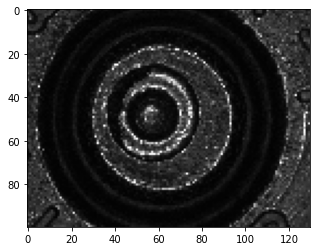

In [23]:
plt.imshow(test_set[34], cmap = "gray")

# Cria os gerador com data augmentation

In [4]:
# def gammaCorrection(src, gamma):
#     invGamma = 1 / gamma
 
#     table = [((i / 255) ** invGamma) * 255 for i in range(256)]
#     table = np.array(table, np.uint8)
 
#     return cv2.LUT(src, table)
    
# def processing(img):
#     img_b = cv2.medianBlur(img, 5)
#     #eq = gammaCorrection(img_b, 2)
#     (T, img) = cv2.threshold(img_b, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     return(np.reshape(np.array(img), input))
    
datagen = ImageDataGenerator(
    #shear_range = 20,
    # width_shift_range = 5,
    # height_shift_range = 5,
    # rotation_range=30,
    # horizontal_flip=True,
    # vertical_flip=True
    # #preprocessing_function=processing
    #zoom_range = 0.2

)

#Weight for class balancing
class_weights = class_weight.compute_class_weight('balanced', np.unique(s_train_labels), s_train_labels)
datagen.fit(np.array(train_set))

C:\Users\sergi\.conda\envs\TF\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['Colt' 'Glock' 'Ruger' 'SW' 'SigSauer'], y=['SigSauer' 'Colt' 'Glock' 'Colt' 'SW' 'SW' 'SW' 'SW' 'Glock' 'Glock'
 'Glock' 'Ruger' 'Colt' 'Glock' 'Colt' 'SigSauer' 'SW' 'SigSauer' 'Colt'
 'Ruger' 'Glock' 'SigSauer' 'Glock' 'SigSauer' 'SigSauer' 'SigSauer'
 'SigSauer' 'Glock' 'Glock' 'Glock' 'Ruger' 'Glock' 'Ruger' 'Ruger'
 'Ruger' 'SigSauer' 'Glock' 'Ruger' 'SW' 'SW' 'SigSauer' 'Colt' 'SW' 'SW'
 'Glock' 'Glock' 'Ruger' 'SW' 'Colt' 'Ruger' 'SW' 'Glock' 'SigSauer'
 'Colt' 'Ruger' 'Ruger' 'Colt' 'Glock' 'SW' 'Glock' 'Ruger' 'Glock'
 'SigSauer' 'Colt' 'SW' 'SW' 'Ruger' 'SigSauer' 'SW' 'Ruger' 'Glock'
 'SigSauer' 'SigSauer' 'Ruger' 'SigSauer' 'SigSauer' 'Ruger' 'Colt' 'SW'
 'SigSauer' 'Colt' 'Colt' 'Glock' 'SigSauer' 'SW' 'Ruger' 'SW' 'SW'
 'Glock' 'SW' 'SigSauer' 'SigSauer' 'SigSauer' 'Ruger' 'SigSauer'
 'SigSauer' 'SigSauer' 'Glock' 'Glock' 'Glock' 'Ruger' 'Ruger' 'SW' 'Colt'
 'Colt

# Mostrar imagens dataset

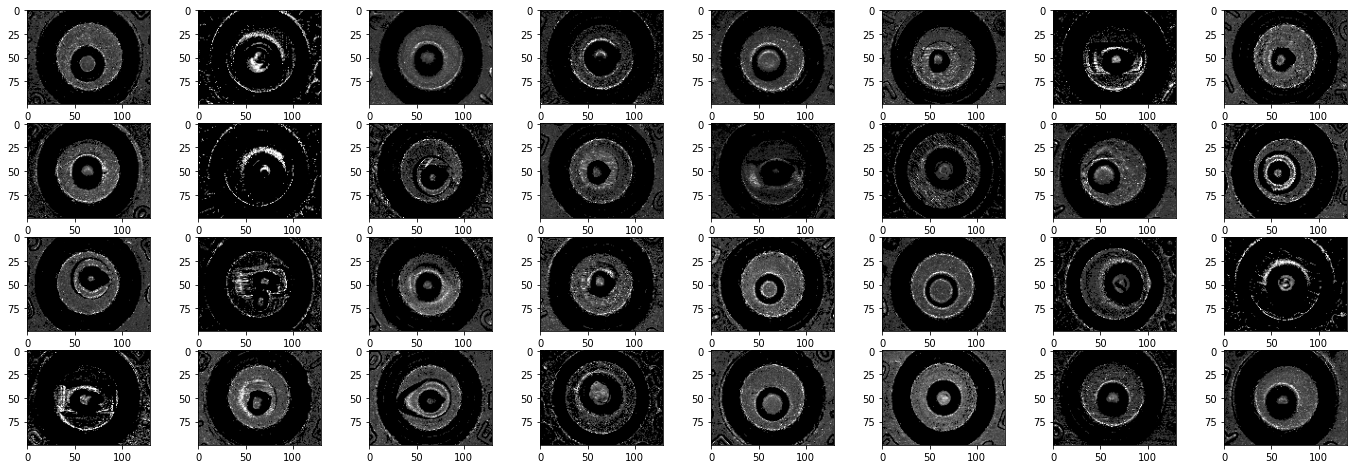

In [5]:
images = datagen.flow(train_set, train_labels, batch_size=32)[0][0]

w = 10
h = 10
fig = plt.figure(figsize=(24, 8))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(images[i-1], cv2.COLOR_BGR2RGB))
plt.show()

# Modelos CNN Keras Tuner

In [4]:
def create_tl_model_tuner(hp):
    p_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape = input, weights = "imagenet", include_top=False)
    p_model.trainable = False
    inputs = p_model.input
    filter_size =  hp.Int("filter_" + str(0), 2, 5)
    x = Conv2D(hp.Int("conv_" + str(0) + "_units", 4, 32, 16), (filter_size, filter_size), activation='relu', padding = "same")(p_model.output)
    pool_size =  hp.Int("pool_" + str(0 + 1), 1, 2)
    x = MaxPool2D(pool_size, pool_size)(x)
    x = Flatten()(x)
    for i in range(hp.Int("n_layers_FC", 0,2)):
        fc =  hp.Int("FC_"+ str(i), 4, 256, 16)
        x = tf.keras.layers.Dense(fc, activation="relu")(x)
    x = Dense(5, activation="softmax")(x)
    model = Model(inputs, x)
    model.summary()
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
    return model

def create_model_hp(hp):
    model = Sequential()
    filter_size =  hp.Int("filter_0", 2,6)
    model.add(Conv2D(hp.Int("conv_0_units", 4, 64, 16), (filter_size, filter_size), activation='relu', input_shape=input))
    pool_size =  hp.Int("pool_" + str(0), 1, 3)
    model.add(MaxPool2D(pool_size, pool_size))
    for i in range(hp.Int("n_layers", 1,3)):
        filter_size =  hp.Int("filter_" + str(i + 1), 2, 5)
        model.add(Conv2D(hp.Int("conv_" + str(i) + "_units", 4, 32, 16), (filter_size, filter_size), activation='relu', input_shape=input))
        pool_size =  hp.Int("pool_" + str(i + 1), 1, 2)
        model.add(MaxPool2D(pool_size, pool_size))
    
    model.add(Flatten())
    for i in range(hp.Int("n_layers_FC", 0,2)):
        fc =  hp.Int("FC_"+ str(i), 4, 256, 16)
        model.add(tf.keras.layers.Dense(fc, activation="relu"))
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
    return model


# Keras Tuner Fit

In [20]:
name = "test"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

tuner = RandomSearch(
    create_model_hp,
    objective='val_accuracy',
    max_trials=2, 
    executions_per_trial=2, 
    directory="test")


tuner.search(train_set, train_labels,
             #datagen.flow(train_set, train_labels, batch_size=32), batch_size=32,
             verbose=1,
             epochs=20,
             callbacks=[tensorboard], 
             validation_data=(val_set[:], val_labels[:]))

best_model = tuner.get_best_models()[0]
print("Val set evaluation")
best_model.evaluate(val_set, val_labels)
#best_model.summary()

Trial 2 Complete [00h 00m 27s]
val_accuracy: 0.909722238779068

Best val_accuracy So Far: 0.909722238779068
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit
Test set evaluation
3/3 [==============================] - 0s 7ms/step - loss: 0.2538 - accuracy: 0.9167


[0.25384652614593506, 0.9166666865348816]

In [21]:
# best_model = tf.keras.models.load_model('models/86_BFR_CNN_100_130_TESTSET_BALANCED.h5')
print("Test set evaluation")
best_model.evaluate(test_set, test_labels)
print("Validation set evaluation")
best_model.evaluate(val_set, val_labels)

Test set evaluation
3/3 [==============================] - 0s 26ms/step - loss: 0.5451 - accuracy: 0.8451
Validation set evaluation
3/3 [==============================] - 0s 5ms/step - loss: 0.2538 - accuracy: 0.9167


[0.25384652614593506, 0.9166666865348816]

# Validar modelos

In [27]:
#Tensorboard Logs
#cmd - tensorboard --logdir=logs/
name = "Best_100_130_Unalanced"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))
#best_model = tf.keras.models.load_model('models/86_BFR_CNN_100_130_TESTSET_BALANCED.h5')
#Get best architecture 
best_model = tf.keras.models.load_model('models/86_BFR_CNN_100_130_TESTSET_BALANCED.h5')
# best_model.summary()
# best_model.evaluate(test_set, test_labels)

#For transfer learning
# train_layers = tf.keras.models.clone_model(best_model).layers[-4:]
# print(train_layers)
# p_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape = input, weights = "imagenet", include_top=False)
# p_model.trainable = False
# inputs = p_model.input
# x=MaxPool2D(1,1)(p_model.output) #layer that doesnt do anything
# for layer in train_layers: # this is where I changed your code
#     print(layer)
#     x = layer(x)  
# initialized_model = Model(inputs, x)
# initialized_model.summary()

#For "regular" models
initialized_model = tf.keras.models.clone_model(best_model)
#initialized_model.summary()

#Saves the best epoch
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_epoch.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Train the model again
initialized_model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
initialized_model.fit(
        train_set, train_labels,
        #datagen.flow(train_set, train_labels, batch_size=32),
        validation_data=(val_set, val_labels),
        batch_size=64,
        callbacks=[model_checkpoint_callback, tensorboard],
        epochs=30)

#initialized_model = tf.keras.models.load_model('best_epoch.h5')
#initialized_model.evaluate(test_set, test_labels)

Epoch 1/30
13/13 [==============================] - 2s 161ms/step - loss: 1.4383 - accuracy: 0.3868 - val_loss: 1.0749 - val_accuracy: 0.6667
Epoch 2/30
13/13 [==============================] - 0s 38ms/step - loss: 0.8406 - accuracy: 0.6854 - val_loss: 0.7947 - val_accuracy: 0.6574
Epoch 3/30
13/13 [==============================] - 1s 42ms/step - loss: 0.5902 - accuracy: 0.8005 - val_loss: 0.5570 - val_accuracy: 0.7593
Epoch 4/30
13/13 [==============================] - 1s 45ms/step - loss: 0.4656 - accuracy: 0.8397 - val_loss: 0.4841 - val_accuracy: 0.7870
Epoch 5/30
13/13 [==============================] - 1s 46ms/step - loss: 0.3554 - accuracy: 0.8960 - val_loss: 0.4640 - val_accuracy: 0.7963
Epoch 6/30
13/13 [==============================] - 0s 38ms/step - loss: 0.2970 - accuracy: 0.8837 - val_loss: 0.6704 - val_accuracy: 0.7222
Epoch 7/30
13/13 [==============================] - 0s 38ms/step - loss: 0.2802 - accuracy: 0.8996 - val_loss: 0.6444 - val_accuracy: 0.7315
Epoch 8/30
1

# Replica melhor modelo

In [42]:
print(len(val_labels))
name = "BFR_100_130_unbalanced"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (4, 4), padding = "same", activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (2, 2),padding = "same", activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (2, 2), padding = "same",activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(212, activation="relu"))
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])    
    return  model

cnn = create_model()
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

cnn.fit(#datagen.flow(train_set, train_labels, batch_size=32),
        train_set, train_labels,
        validation_data=(val_set, val_labels),
        batch_size=16,
        callbacks=[model_checkpoint_callback],
        epochs=30)

72
Epoch 1/10
36/36 [==============================] - 1s 29ms/step - loss: 1.6119 - accuracy: 0.1916 - val_loss: 1.6092 - val_accuracy: 0.1944
Epoch 2/10
36/36 [==============================] - 1s 21ms/step - loss: 1.6092 - accuracy: 0.1794 - val_loss: 1.6094 - val_accuracy: 0.1944
Epoch 3/10
36/36 [==============================] - 1s 21ms/step - loss: 1.6093 - accuracy: 0.1934 - val_loss: 1.6094 - val_accuracy: 0.1944
Epoch 4/10
36/36 [==============================] - 1s 22ms/step - loss: 1.6089 - accuracy: 0.2091 - val_loss: 1.6094 - val_accuracy: 0.1944
Epoch 5/10
36/36 [==============================] - 1s 23ms/step - loss: 1.6087 - accuracy: 0.2091 - val_loss: 1.6094 - val_accuracy: 0.1944
Epoch 6/10
36/36 [==============================] - 1s 23ms/step - loss: 1.6088 - accuracy: 0.2091 - val_loss: 1.6097 - val_accuracy: 0.1944
Epoch 7/10
36/36 [==============================] - 1s 23ms/step - loss: 1.6089 - accuracy: 0.2091 - val_loss: 1.6097 - val_accuracy: 0.1944
Epoch 8/10

# Modelo Transfer Learning

In [12]:
print(len(train_labels))
name = "BFR_100_130_unbalanced"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

def create_model():
    p_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape = input, weights = "imagenet", include_top=False)
    p_model.trainable = False
    inputs = p_model.input
    x = Flatten()(p_model.output)
    x = Dense(5, activation="softmax")(x)
    model = Model(inputs, x)
    model.summary()
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
    return model

cnn = create_model()
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

cnn.fit(#datagen.flow(train_set, train_labels, batch_size=32),
        train_set, train_labels,
        validation_data=(val_set, val_labels),
        batch_size=16,
        callbacks=[model_checkpoint_callback],
        epochs=30)

175
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 130, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 136, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 65, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 67, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________

(72, 100, 130, 1)
3/3 [==============================] - 0s 7ms/step - loss: 0.5255 - accuracy: 0.8194
[0.5254698991775513, 0.8194444179534912]


[Text(0.5, 1.0, 'Confusion_Matrix'),
 Text(0.5, 15.0, 'predicted labels'),
 Text(33.0, 0.5, 'true labels')]

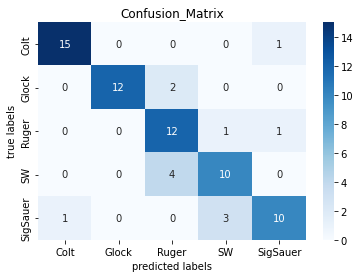

In [38]:
#best = tf.keras.models.load_model('models/86_BFR_CNN_100_130_TESTSET_BALANCED.h5')
best = cnn 
le = preprocessing.LabelEncoder()

print(val_set.shape)

y = tf.argmax(input=best.predict(val_set), axis=1)
encoded_labels = le.fit_transform(s_val_labels)
confusion = tf.math.confusion_matrix(labels=encoded_labels, predictions=y, num_classes=5)
train_acc = best.evaluate(val_set, val_labels)
print(train_acc)
classes = np.unique(s_train_labels)

ax = sns.heatmap(confusion, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes)
ax.set(title="Confusion_Matrix", xlabel="predicted labels", ylabel="true labels")



# Visualize filters

0 conv2d_79 (None, 100, 130, 32)
2 conv2d_80 (None, 50, 65, 32)
3 conv2d_81 (None, 50, 65, 32)
4 conv2d_82 (None, 50, 65, 64)
5 conv2d_83 (None, 50, 65, 128)
6 conv2d_84 (None, 50, 65, 32)
7 conv2d_85 (None, 50, 65, 32)
(100, 130, 1)
[[[[0.         0.         0.         ... 0.00182616 0.
    0.00923986]
   [0.01283804 0.         0.00620164 ... 0.02274408 0.
    0.02299014]
   [0.06138951 0.         0.         ... 0.0442181  0.00192563
    0.01039577]
   ...
   [0.         0.00965646 0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.00018159]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.00373726 0.         ... 0.00999305 0.
    0.00767803]
   [0.00419435 0.         0.00310633 ... 0.02430995 0.
    0.0134631 ]
   [0.04125895 0.         0.         ... 0.0313662  0.00808536
    0.00073867]
   ...
   [0.         0.00388986 0.         ... 0.         0.
    0.        ]
   [0.         0.       

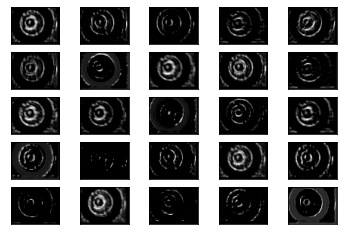

In [37]:
# model = tf.keras.models.load_model('models/86_BFR_CNN_100_130_TESTSET_BALANCED.h5')
model = cnn
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)
model = Model(inputs=model.inputs, outputs=model.layers[7].output)

print(test_set[27].shape)
feature_maps = model.predict(np.reshape(test_set[34], (1,100,130,1)))
print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 5
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

# Siamese NN

In [13]:
def pair_generator(img_list, label_list, batch_size=200):
    classes = labels
    a = []
    p = []
    n = []
    for x in range(int(batch_size/2)):
        p_n = random.sample(list(classes), 2)
        pos = p_n[0]
        neg = p_n[1]
        #Select anchor and positive sample 
        positives = random.sample(list(img_list[label_list == pos]), 2)
        #Select negative sample 
        negative = random.choice(list(img_list[label_list == neg]))
        a.append(positives[0])
        p.append(positives[1])
        n.append(negative)
    
    pairs = [[x, y] for x, y in zip(a, p)]
    [pairs.append([y, x]) for x, y in zip(a, n)]
    print(pairs)
    pairs_labels = list(np.ones((len(p))))
    pairs_labels.extend(np.zeros((len(n))))
    pairs, pairs_labels= shuffle(pairs, pairs_labels)
    
    return np.asarray(pairs), np.asarray(pairs_labels, dtype=np.int32)



def batch_pair_generator(batch_size=32):
    classes = labels
    while True:
        a = []
        p = []
        n = []
        pairs=[]
        for x in range(int(batch_size/2)):
            p_n = random.sample(list(classes), 2)
            pos = p_n[0]
            neg = p_n[1]
            #Select anchor and positive sample 
            positives = random.sample(list(train_set[s_train_labels == pos]), 2)
            #Select negative sample 
            negative = random.choice(list(train_set[s_train_labels == neg]))
            a.append(positives[0])
            p.append(positives[1])
            n.append(negative)
        
        pairs = [[x, y] for x, y in zip(a, p)]
        [pairs.append([y, x]) for x, y in zip(a, n)]
        pairs_labels = list(np.ones((len(p))))
        pairs_labels.extend(np.zeros((len(n))))
        pairs, pairs_labels= shuffle(pairs, pairs_labels)
        pairs, pairs_labels = np.array(pairs), np.array(pairs_labels)
        yield [pairs[:,0], pairs[:,1]],pairs_labels[:]

# train_pairs, train_label_pairs = pair_generator(train_set, s_train_labels, batch_size=1500)
test_pairs, test_label_pairs = pair_generator(val_set, s_val_labels, batch_size=400)
# print(train_pairs.shape)

[[array([[[0.09019608, 0.09019608, 0.09019608],
        [0.09803922, 0.09803922, 0.09803922],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.04705882, 0.04705882, 0.04705882],
        [0.09411765, 0.09411765, 0.09411765],
        [0.14901961, 0.14901961, 0.14901961]],

       [[0.17647059, 0.17647059, 0.17647059],
        [0.21568627, 0.21568627, 0.21568627],
        [0.09803922, 0.09803922, 0.09803922],
        ...,
        [0.18823529, 0.18823529, 0.18823529],
        [0.14117647, 0.14117647, 0.14117647],
        [0.12156863, 0.12156863, 0.12156863]],

       [[0.3372549 , 0.3372549 , 0.3372549 ],
        [0.2       , 0.2       , 0.2       ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.02352941, 0.02352941, 0.02352941],
        [0.05098039, 0.05098039, 0.05098039]],

       ...,

       [[0.08235294, 0.08235294, 0.08235294],
        [0.06666667, 0.06666667, 0.06666667],
        [0.09019608,

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
    
def get_siamese_model(hp):
    #two input images 
    left_input = Input(input)
    right_input = Input(input)
    
    # Convolutional Neural Network to extract feature vector
    model = Sequential()
    
    filter_size =  hp.Int("filter_0", 2,6)
    model.add(Conv2D(hp.Int("conv_0_units", 4, 64, 16), (filter_size, filter_size), activation='relu', input_shape=input))
    model.add(MaxPool2D(3, 3))
    for i in range(hp.Int("n_layers", 0,3)):
        filter_size =  hp.Int("filter_" + str(i + 1), 1, 6)
        model.add(Conv2D(hp.Int("conv_" + str(i) + "_units", 4, 64, 16), (filter_size, filter_size), activation='relu'))
        pool_size =  hp.Int("pool_" + str(i + 1), 1, 3)
        model.add(MaxPool2D(pool_size, pool_size))
    
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(128, activation="sigmoid"))

    # feature vectors for each image of the pair
    encoded_l = model(left_input)
    encoded_r = model(right_input)


    # absolute difference between the feature vectors
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    #L1_distance = euclidean_distance([encoded_l, encoded_r])
    
    # sigmoid layer to predict similarity 
    prediction = Dense(1,activation='softmax')(L1_distance)
    
    # connect inputs with outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    siamese_net.compile(loss = "binary_crossentropy", optimizer= "Adam", metrics=["accuracy"])


    return siamese_net

def get_siamese_model_tl(hp):
    #two input images 
    left_input = Input(input)
    right_input = Input(input)
    
    # Convolutional Neural Network to extract feature vector
    model = Sequential()

    p_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = input, weights = "imagenet", include_top=False)
    p_model.trainable = False
    inputs = p_model.input
    x = Flatten()(p_model.output)
    n_layers =  hp.Int("layers2" + str(1), 8, 512, 32)
    x = Dense(n_layers, activation="relu")(x)
    model = Model(inputs, x)

    # feature vectors for each image of the pair
    encoded_l = model(left_input)
    encoded_r = model(right_input)


    # absolute difference between the feature vectors
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    print(L1_distance[0])
    #L1_distance = euclidean_distance([encoded_l, encoded_r])
    
    # sigmoid layer to predict similarity 
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # connect inputs with outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    siamese_net.compile(loss = "binary_crossentropy", optimizer= "Adam", metrics=["accuracy"])


    return siamese_net


#Using the best CNN to construct a SNN
def siamese_model():
    #two input images 
    left_input = Input(input)
    right_input = Input(input)

    # Convolutional Neural Network to extract feature vector
    model = Sequential()
    model.add(Conv2D(32, (4, 4), padding = "same", activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (2, 2),padding = "same", activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (2, 2), padding = "same",activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(212, activation="sigmoid"))

    # feature vectors for each image of the pair
    encoded_l = model(left_input)
    encoded_r = model(right_input)


    # absolute difference between the feature vectors
    #subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    #L1_distance = euclidean_distance([encoded_l, encoded_r])
    
    # sigmoid layer to predict similarity 
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # connect inputs with outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    siamese_net.compile(loss = "binary_crossentropy", optimizer= "Adam", metrics=["accuracy"])

    return siamese_net

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_siamese.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model = siamese_model()
model.fit(batch_pair_generator(batch_size=200), 
        validation_data = ([test_pairs[:,0], test_pairs[:,1]], 
        test_label_pairs[:]), 
        callbacks=model_checkpoint_callback, 
        steps_per_epoch = 100, 
        epochs=6)
# tuner = RandomSearch(
#     get_siamese_model_tl,
#     objective='val_accuracy',
#     max_trials=30,  # how many model variations to test?
#     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
#     directory="50_50")


# tuner.search(batch_pair_generator(), steps_per_epoch = 10,
#              verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
#              epochs=15,
#              callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=4)],  # if you have callbacks like tensorboard, they go here.
#              validation_data=([test_pairs[:,0], test_pairs[:,1]], test_label_pairs[:]))


# tuner.results_summary()
# model = tuner.get_best_models()[0]
# model.save("siamese_400_400.h5")

Epoch 1/6
100/100 [==============================] - 100s 995ms/step - loss: 0.3723 - accuracy: 0.8286 - val_loss: 0.7771 - val_accuracy: 0.6150
Epoch 2/6
100/100 [==============================] - 104s 1s/step - loss: 0.0474 - accuracy: 0.9974 - val_loss: 1.0980 - val_accuracy: 0.6375
Epoch 3/6
100/100 [==============================] - 103s 1s/step - loss: 0.0133 - accuracy: 0.9998 - val_loss: 1.2717 - val_accuracy: 0.6375
Epoch 4/6
100/100 [==============================] - 102s 1s/step - loss: 0.0079 - accuracy: 0.9998 - val_loss: 1.3145 - val_accuracy: 0.6375
Epoch 5/6
 32/100 [========>.....................] - ETA: 1:08 - loss: 0.0060 - accuracy: 0.9998

# Accuracy using distances

In [21]:

#model = tf.keras.models.load_model('siamese83_80_80.h5')
# tuner.results_summary()
# model = tuner.get_best_models()[0]
print(model.layers)
model = model.layers[2]

def accuracy():
    correct = 0
    val_coords =  model.predict(np.array(val_set))
    test_coords = model.predict(np.array(train_set))
    for i,l in zip(val_coords, s_val_labels):
        distances = []
        coord = i
        for j in labels:
            model_imgs = list(test_coords[s_train_labels == j])
            dist = 0
            for gun_img in model_imgs:
                dist += np.linalg.norm(coord - gun_img)
            dist = dist/len(model_imgs)
            distances.append(dist)
        print(distances)
        label_p = distances.index(min(distances))
        label_a = list(labels).index(l)

        if(label_a==label_p): 
            correct+=1
    
    return correct/len(val_coords)
accuracy()


[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016188797B88>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016188798F88>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001618CF9F908>, <tensorflow.python.keras.layers.core.Lambda object at 0x00000160F1036808>, <tensorflow.python.keras.layers.core.Dense object at 0x000001618CFBA248>]
[6.665735155849133, 7.877690780162811, 7.616935023555049, 3.90587829152743, 5.510376848556377]
[4.196082377837876, 8.38687868118286, 7.683197171599777, 6.09570351044337, 7.435732867982653]
[8.724218134152688, 3.5996909936269126, 6.795594100598936, 8.031520740191143, 6.608167039023505]
[8.55304536172899, 4.128422985474269, 6.3245366546842785, 7.349244185288748, 5.743048517792313]
[8.884860252929947, 3.8431006133556367, 6.833812351580019, 8.142030163606007, 6.697753195409422]
[6.677299313626047, 7.644476580619812, 7.373088351002446, 3.8209672808647155, 5.320712681169863]
[6.40703260696540

0.8333333333333334

In [ ]:
#Further train the best network
model = tf.keras.models.load_model('siamese83_80_80.h5')

#Faz reset ao modelo (elimina os pesos)
model = tf.keras.models.clone_model(model)
model.compile(loss = "binary_crossentropy", optimizer= "ADAM", metrics=["accuracy"])


model.fit(batch_pair_generator(), steps_per_epoch = 100,
verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
            epochs=15,
            validation_data=([test_pairs[:,0], test_pairs[:,1]], test_label_pairs[:])
         )

In [ ]:
from sklearn.model_selection import train_test_split

X_train = model.predict(train_set)
X_test = model.predict(test_set)
y_train = s_train_labels
y_test = s_test_labels

# Random forest on top of SNN

In [ ]:

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# SVM on top of SNN

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


# KNN on top SNN

In [ ]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
labels_encoded=le.fit_transform(s_test_labels)

X_train, X_test, y_train, y_test = train_test_split(model.predict(test_set), labels_encoded, test_size=0.2)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn.fit(X_train,y_train)

#Predict Output
predicted= knn.predict(X_test) 
print(predicted)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

In [ ]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
labels_encoded=le.fit_transform(s_val_labels)

X_test = model.predict(val_set)
y_test = labels_encoded
# 
#Predict Output
predicted= knn.predict(X_test) 
print(predicted)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

# Triplet Loss


In [ ]:
import umap

train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges/Train"
labels = os.listdir(train_path)

def triplet_generator(batch_size=64):
    classes = labels
    while True:
        a = []
        p = []
        n = []
        for x in range(batch_size):
            p_n = random.sample(list(classes), 2)
            pos = p_n[0]
            neg = p_n[1]
            #Select anchor and positive sample 
            positives = random.sample(list(train_set[s_train_labels == pos]), 2)
            #Select negative sample 
            negative = random.choice(list(train_set[s_train_labels == neg]))
            a.append(positives[0])
            p.append(positives[1])
            n.append(negative)
        yield ([np.array(a),np.array(p),np.array(n)], np.zeros((batch_size,1)).astype("float32"))

def triplet_generator_test(batch_size=100):
    classes = labels
    a = []
    p = []
    n = []
    for x in range(batch_size):
        p_n = random.sample(list(classes), 2)
        pos = p_n[0]
        neg = p_n[1]
        #Select anchor and positive sample 
        positives = random.sample(list(test_set[s_test_labels == pos]), 2)
        #Select negative sample 
        negative = random.choice(list(test_set[s_test_labels == neg]))
        a.append(positives[0])
        p.append(positives[1])
        n.append(negative)
    return ([np.array(a),np.array(p),np.array(n)], np.zeros((batch_size,1)).astype("float32"))

def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:,0:50] 
    positive_out = y_pred[:,50:100] 
    negative_out = y_pred[:,100:150] 

    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis = 1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis = 1)

    probs = K.softmax([pos_dist, neg_dist], axis = 0)

    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))



def accuracy():
    correct = 0
    val_coords =  trip_model.layers[3].predict(np.array(val_set))
    test_coords = trip_model.layers[3].predict(np.array(test_set))
    for i,l in zip(val_coords, s_val_labels):
        distances = []
        coord = i
        for j in labels:
            model_imgs = list(test_coords[s_test_labels == j])
            dist = 0
            for gun_img in model_imgs:
                dist += np.linalg.norm(coord - gun_img)
            dist = dist/len(model_imgs)
            distances.append(dist)
        print(distances)
        label_p = distances.index(min(distances))
        label_a = list(labels).index(l)

        if(label_a==label_p): 
            correct+=1
    
    return correct/len(val_coords)

inputs = Input(input)
x = Conv2D(32, (3,3), activation="relu")(inputs)
x = MaxPool2D((3,3))(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = MaxPool2D((3,3))(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)

model = Model(inputs, x)
model.summary()

trip_a = Input(input) 
trip_p = Input(input) 
trip_n = Input(input) 

trip_out = Concatenate()([model(trip_a), model(trip_p), model(trip_n)])
trip_model = Model([trip_a, trip_p, trip_n], trip_out)

trip_model.summary()

trip_model.compile(loss=triplet_loss, optimizer="adam")

testing = triplet_generator_test(100)

trip_model.fit(triplet_generator(), validation_data = testing, steps_per_epoch = 100, epochs = 3)

accuracy()


In [ ]:
import umap

label_encoder = preprocessing.LabelEncoder()
test_lab = label_encoder.fit_transform(s_test_labels)

embbedings=trip_model.layers[3].predict(test_set, verbose = 1)
embbedings_t=trip_model.layers[3].predict(train_set, verbose = 1)

embbedings_reduced = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings)
embbedings_reduced_t = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings_t)

plt.scatter(embbedings_reduced[:,0], embbedings_reduced[:,1], c=test_lab)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
test_lab = label_encoder.fit_transform(s_train_labels)

embbedings=trip_model.layers[3].predict(test_set, verbose = 1)
embbedings_t=trip_model.layers[3].predict(train_set, verbose = 1)

embbedings_reduced = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings)
embbedings_reduced_t = umap.UMAP(n_neighbors = 15, min_dist = 0.3, metric="correlation").fit_transform(embbedings_t)

plt.scatter(embbedings_reduced_t[:,0], embbedings_reduced_t[:,1], c=test_lab)